# Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd

from fastai.vision import *
from fastai.vision.models.xresnet import *

# for datablock API
from fastai.vision.image import _resolve_tfms, _get_crop_target, _round_multiple, _get_resize_target, _affine_grid, _grid_sample, _affine_mult

# for AdvXResNet
from fastai.vision.models.xresnet import act_fn, init_cnn, conv, noop, conv_layer, ResBlock, filt_sz


In [3]:
from nb_new_data_augmentation import *

In [4]:
import pdb

In [5]:
__version__

'1.0.55'

# 6D image test

In [6]:
class Image6D(Image):
    "Support applying transforms to image data in `px`."
    def __init__(self, px:Tensor):
        self._px = px
        self._logit_px=None
        self._flow=None
        self._affine_mat=None
        self.sample_kwargs = {}

    def _repr_image_format(self, format_str):
        with BytesIO() as str_buffer:
            #plt.imsave(str_buffer, image2np(self.px[:3]), format=format_str)
            plt.imsave(str_buffer, 
                       np.concatenate((image2np(self.px[:3]), 
                                       image2np(self.px[3:])), axis=1),
                       format=format_str)
            return str_buffer.getvalue()

In [7]:
def open_image_6D(fn:PathOrStr, div:bool=True, convert_mode:str='L', cls:type=Image6D,
        after_open:Callable=None)->Image:
    "Return `Image` object created from image in file `fn`."
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
        
        x = []
        for i in range(6):
            c = PIL.Image.open(fn+'_w'+str(i+1)+'.png').convert(convert_mode)
            if after_open: c = after_open(c)
            c = np.asarray(c)
            c = torch.from_numpy(c.astype(np.float32, copy=False))
            x.append(c)
            
    x = torch.stack(x)
    if div: x.div_(255)
    return cls(x)

In [8]:
#PATH_trunc = 'train/HEPG2-01/Plate1/B02_s1' # path is missing suffix "_w1.png"
#open_image_6D(PATH_trunc)

# Dataset setup

In [9]:
class ImageList6D(ImageList): #ImageList
    def __init__(self, *args, convert_mode='L', after_open:Callable=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.convert_mode,self.after_open = convert_mode,after_open
        self.copy_new.append('convert_mode')
        self.c,self.sizes = 6,{}
        
    def open(self, fn):
        "Open image in `fn`, subclass and overwrite for custom behavior."
        return open_image_6D(fn, convert_mode=self.convert_mode, after_open=self.after_open)

#    def show(self, img):
#        #return torch.cat((img[i][:3], img[i][3:]), dim=1)
#        show_image(img)
    
    # https://docs.fast.ai/tutorial.itemlist.html#Advanced-show-methods
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(15,10), **kwargs):
        "Show the `xs` and `ys` on a figure of `figsize`. `kwargs` are passed to the show method."
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            #xs[i].show(ax=ax, y=ys[i], **kwargs)
            img = Image6D(torch.cat((xs[i].data[:3], xs[i].data[3:]), dim=2)) # works but not elegant?
            #img = Image6D(xs[i]) # does not work?
            img.show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()

In [10]:
#def show_image(img:Image, ax:plt.Axes=None, figsize:tuple=(3,3), hide_axis:bool=True, cmap:str='binary',
#                alpha:float=None, **kwargs)->plt.Axes:
#    "Display `Image` in notebook."
#    if ax is None: fig,ax = plt.subplots(figsize=figsize)
#    pdb.set_trace()
#    #ax.imshow(image2np(img.data), cmap=cmap, alpha=alpha, **kwargs)
#    ax.imshow(np.concatenate((image2np(self.px[:3]),
#                              image2np(self.px[3:])), axis=1),
#              cmap=cmap, alpha=alpha, **kwargs)
#    if hide_axis: ax.axis('off')
#    return ax


## Full dataset

### Dataset parameters full dataset

In [11]:
df_train = pd.read_csv('full_train_dataset_valid-split-ex_v1_20190714.csv', index_col=0)
df_test = pd.read_csv('full_test_dataset_v1_20190714.csv', index_col=0)

In [12]:
df_train.head()

,path,experiment,sirna,multi,valid
0,HEPG2-01/Plate1/B03_s1,HEPG2-01,513,HEPG2-01 513,0
1,HEPG2-01/Plate1/B04_s1,HEPG2-01,840,HEPG2-01 840,0
2,HEPG2-01/Plate1/B05_s1,HEPG2-01,1020,HEPG2-01 1020,0
3,HEPG2-01/Plate1/B06_s1,HEPG2-01,254,HEPG2-01 254,0
4,HEPG2-01/Plate1/B07_s1,HEPG2-01,144,HEPG2-01 144,0


In [13]:
df_test.head()

,path,experiment
0,HEPG2-08/Plate1/B03_s1,HEPG2-08
1,HEPG2-08/Plate1/B04_s1,HEPG2-08
2,HEPG2-08/Plate1/B05_s1,HEPG2-08
3,HEPG2-08/Plate1/B06_s1,HEPG2-08
4,HEPG2-08/Plate1/B07_s1,HEPG2-08


### Color augmentation transformation

"Color Augmentation: Color variability can be increased by applying random color transformations to original training samples. We perform color augmentation by transforming every color channels Ic ← ac · Ic + bc, where ac and bc are drawn from uniform distributions ac ∼ U [0.9, 1.1] and bc ∼ U [−10, +10]." from Domain-adversarial neural networks to address the appearance variability of histopathology images

In [14]:
# from https://github.com/fastai/fastai/blob/master/fastai/vision/transform.py#L137
#def _rgb_randomize(x, channel:int=None, thresh:float=0.3):
#    "Randomize one of the channels of the input image"
#    if channel is None: channel = np.random.randint(0, x.shape[0] - 1)
#    x[channel] = torch.rand(x.shape[1:]) * np.random.uniform(0, thresh)
#    return x
#
#rgb_randomize = TfmPixel(_rgb_randomize)

In [15]:
# Scaling factor comes from byte tensor?
#10/255 = 0.0392156862745098

In [16]:
def _color_augmentation(x):
    "Randomize all channels of the input image"
    channel_count = x.shape[0] - 1
    
    # by transforming every color channels Ic ← ac · Ic + bc, 
    # where ac and bc are drawn from uniform distributions 
    # ac ∼ U [0.9, 1.1] and 
    # bc ∼ U [−10, +10].
    
    # x [0,1]
    
    for c in range(channel_count):
        #pdb.set_trace()
        #print(x.min(), x.max())
        ac = np.random.uniform(0.9, 1.1) #np.random.uniform(0.9, 1.1)
        bc = np.random.uniform(-0.1,0.1) #np.random.uniform(-10, 10)
        x[c] = x[c] * ac + bc
        
        # clipping to min 0 and max 1
        x[c] = torch.clamp(x[c], 0., 1.)
    
    return x

color_augmentation = TfmPixel(_color_augmentation)

### Transforms setup

In [17]:
## ResNet50pt
#sz, bs = 96, 8*46 # 77560MiB /  7952MiB

## XResNet50c
#sz, bs = 96, 8*46 # 7573MiB /  7952MiB
#sz, bs = 128, 8*52 # 7935MiB /  7952MiB
#sz, bs = 256, 8*13 # 7929MiB /  7952MiB
#sz, bs = 512, 8*3 # 7575MiB /  7952MiB

## XResNet50c AdaCos
#sz, bs = 128, 8*50 # 7846MiB /  7952MiB

## XResNet152fh
#sz, bs = 128, 8*23 # 7919MiB /  7952MiB

## SE_XResNet152fh
#sz, bs = 128, 8*18 # 7752MiB /  7952MiB
#sz, bs = 256, 8*4 # 7639MiB /  7952MiB
sz, bs = 512, 8 # 

In [18]:
sz, bs

(512, 8)

In [19]:
# normal tfms
#tfms = get_transforms()

# extended tfms
tfms = get_transforms(do_flip=True, flip_vert=True, 
                      max_rotate=90.0, max_zoom=1.1, 
                      max_lighting=0.2, max_warp=0.2, 
                      p_affine=0.75, p_lighting=0.75, 
                      xtra_tfms=color_augmentation())

In [20]:
# future transform mix?

### Full dataset

In [21]:
data = (ImageList6D.from_df(df_train, path='train')
        .split_from_df(col=-1) # split_by_rand_pct()
        .label_from_df(cols=-3) # label_delim=' ' for MultiCategoryList !
        .add_test(ImageList6D.from_df(df_test, path='test'))
        .transform(tfms, size=sz) # .transform(size=sz)
        .databunch(bs=bs))

In [22]:
data

ImageDataBunch;

Train: LabelList (28777 items)
x: ImageList6D
Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512)
y: CategoryList
513,840,1020,254,144
Path: train;

Valid: LabelList (7738 items)
x: ImageList6D
Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512)
y: CategoryList
352,361,503,505,70
Path: train;

Test: LabelList (19897 items)
x: ImageList6D
Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512)
y: EmptyLabelList
,,,,
Path: train

In [25]:
data.c, len(data.classes), data.classes[-5:]

(1108, 1108, [1103, 1104, 1105, 1106, 1107])

In [26]:
data.train_ds[0]

(Image6D (6, 128, 128), Category 513)

In [24]:
#data.classes

In [25]:
data.train_ds[0][1], data.train_ds[0][1].data

(Category 513, 513)

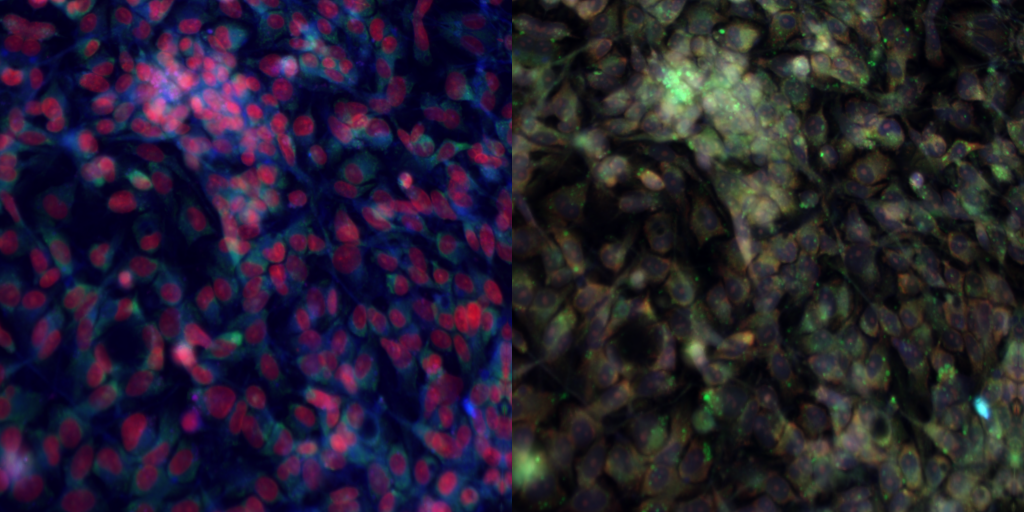

In [23]:
data.train_ds[0][0]

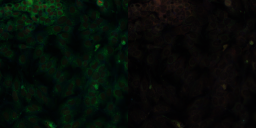

In [27]:
data.test_ds[0][0]

### Adversarial full dataset

In [32]:
data_a = (ImageList6D.from_df(df_train, path='train') # SET CORRECT DF!!!
        .split_from_df(col=-1) # split_by_rand_pct()
        .label_from_df(cols=-2, label_delim=' ') # label_delim=' ' for MultiCategoryList !
        .add_test(ImageList6D.from_df(df_train, path='train'))
        .transform(tfms, size=sz) # .transform(size=sz)
        .databunch(bs=bs))

In [282]:
data_a

ImageDataBunch;

Train: LabelList (33191 items)
x: ImageList6D
Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128)
y: MultiCategoryList
HEPG2-01;513,HEPG2-01;840,HEPG2-01;1020,HEPG2-01;254,HEPG2-01;144
Path: train;

Valid: LabelList (3324 items)
x: ImageList6D
Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128)
y: MultiCategoryList
267,768,632,86,1051
Path: train;

Test: None

In [283]:
data_a.c, len(data_a.classes), data_a.classes[-5:]

(1138, 1138, ['RPE-03', 'RPE-04', 'RPE-05', 'RPE-06', 'RPE-07'])

In [284]:
data_a.batch_size

208

In [285]:
data_a.train_ds[0]

(Image6D (6, 128, 128), MultiCategory HEPG2-01;513)

In [286]:
#data_a.classes

In [287]:
data_a.train_ds[0][1], data_a.train_ds[0][1].data

(MultiCategory HEPG2-01;513,
 array([0., 0., 0., 0., ..., 0., 0., 0., 0.], dtype=float32))

In [288]:
data_a.train_ds[0][1].data.sum()

2.0

In [289]:
np.where(data_a.train_ds[0][1].data > 0.5)

(array([ 569, 1108]),)

In [290]:
[data_a.classes[j] for j in np.where(data_a.train_ds[0][1].data > 0.5)[0]]

['513', 'HEPG2-01']

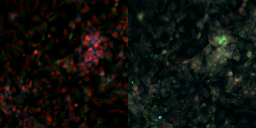

In [291]:
data_a.train_ds[0][0]

In [292]:
# DOES NOT WORK?
#data_a.train_ds[0][0].show()

# Model setup

## ResNet152 pretrained

In [84]:
learn = cnn_learner(data, models.resnet152, metrics=accuracy)

In [85]:
# gives an error, because expects 6-channel weight in first conv layer
#learn.summary()

In [86]:
#learn.model

In [87]:
learn.model[0][0], type(learn.model[0][0])

(Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 torch.nn.modules.conv.Conv2d)

In [88]:
torch.nn.modules.conv.Conv2d is nn.Conv2d

True

In [89]:
p_dict = {pn: p for pn, p in learn.model[0][0].named_parameters()}

In [90]:
p_dict['weight'].shape, p_dict['weight'].requires_grad

(torch.Size([64, 3, 7, 7]), False)

In [91]:
old_weight = p_dict['weight'].detach()

In [92]:
old_weight.shape, old_weight.requires_grad

(torch.Size([64, 3, 7, 7]), False)

In [93]:
new_weight = torch.cat((old_weight, old_weight), dim=1)

In [94]:
new_weight.shape, new_weight.requires_grad

(torch.Size([64, 6, 7, 7]), False)

In [95]:
# replace first conv layer with a 6-channel version
learn.model[0][0] = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [96]:
learn.model[0][0]

Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [97]:
learn.model[0][0].weight.shape

torch.Size([64, 6, 7, 7])

In [98]:
# set new_weights to nn.Parameter and overwrite it in the conv layer
learn.model[0][0].weight = nn.Parameter(new_weight) # hand over requires_grad False?

In [99]:
# check if weight was loaded properly
assert torch.allclose(new_weight, learn.model[0][0].weight)

In [100]:
learn.model[0][0].weight.shape, learn.model[0][0].weight.requires_grad

(torch.Size([64, 6, 7, 7]), True)

In [101]:
# freeze input stage to only train output stage
#learn.freeze()
# DOES NOT WORK FOR INPUT CONV LAYER?

In [102]:
learn.model[0][0].weight.requires_grad = False

In [103]:
# check if layer is trainable and model looks fine
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 48, 48]         18,816     False     
______________________________________________________________________
BatchNorm2d          [64, 48, 48]         128        True      
______________________________________________________________________
ReLU                 [64, 48, 48]         0          False     
______________________________________________________________________
MaxPool2d            [64, 24, 24]         0          False     
______________________________________________________________________
Conv2d               [64, 24, 24]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 24, 24]         128        True      
______________________________________________________________________
Conv2d               [64, 24, 24]         36,864     False     
___________________________________________________

In [104]:
learn.model(torch.randn(1,6,sz,sz).cuda()).shape

torch.Size([1, 1108])

In [105]:
learn.model(data.train_ds[0][0].data.unsqueeze(0).cuda()).shape

torch.Size([1, 1108])

## XResNet152

In [35]:
xresnet152c = XResNet(4, [3,8,36,3], c_in=6, c_out=1108)

In [36]:
#xresnet152c

In [37]:
xresnet152c(torch.randn(1,6,sz,sz)).shape

torch.Size([1, 1108])

In [38]:
xresnet152c(data.train_ds[0][0].data.unsqueeze(0)).shape

torch.Size([1, 1108])

## AdvXResNet152

In [25]:
class AdvXResNet(nn.Sequential):
    def __init__(self, expansion, layers, c_in=6, c_out=1108, c_out_a=33):
        stem = []
        sizes = [c_in,32,32,64]
        for i in range(3):
            stem.append(conv_layer(sizes[i], sizes[i+1], stride=2 if i==0 else 1))
            #nf = filt_sz(c_in*9)
            #stem.append(conv_layer(c_in, nf, stride=2 if i==1 else 1))
            #c_in = nf

        block_szs = [64//expansion,64,128,256,512]
        blocks = [self._make_layer(expansion, block_szs[i], block_szs[i+1], l, 1 if i==0 else 2)
                  for i,l in enumerate(layers)]
        super().__init__(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *blocks,
            #nn.AdaptiveAvgPool2d(1), Flatten(),
            #nn.Linear(block_szs[-1]*expansion, c_out),
            output_a(block_szs, expansion, c_out, c_out_a)
        )
        init_cnn(self)

    def _make_layer(self, expansion, ni, nf, blocks, stride):
        return nn.Sequential(
            *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1)
              for i in range(blocks)])

In [26]:
# https://github.com/janfreyberg/pytorch-revgrad v0.1
from torch.autograd import Function

class RevGrad(Function):
    @staticmethod
    def forward(ctx, input_):
        ctx.save_for_backward(input_)
        output = input_
        return output

    @staticmethod
    def backward(ctx, grad_output):  # pragma: no cover
        grad_input = None
        if ctx.needs_input_grad[0]:
            grad_input = grad_output * ifnone(learn_a.opt.gr,0) # Gradient reversal !!!
            #print(learn_a.opt.gr)
        return grad_input


revgrad = RevGrad.apply

class RevGrad(Module):
    def __init__(self, *args, **kwargs):
        """
        A gradient reversal layer.
        This layer has no parameters, and simply reverses the gradient
        in the backward pass.
        """

        super().__init__(*args, **kwargs)

    def forward(self, input_):
        return revgrad(input_)

In [27]:
class output_a(Module):
    def __init__(self, block_szs, expansion, c_out, c_out_a):
        self.c_out, self.c_out_a = c_out, c_out_a
        
        self.AAP = nn.AdaptiveAvgPool2d(1)
        self.flatten = Flatten()
        
        self.lin_label1 = nn.Linear(block_szs[-1]*expansion, block_szs[-1]*expansion)
        self.lin_label2 = nn.Linear(block_szs[-1]*expansion, c_out)
        
        self.lin_domain1 = nn.Linear(block_szs[-1]*expansion, block_szs[-1]*expansion)
        self.lin_domain2 = nn.Linear(block_szs[-1]*expansion, c_out_a)
        
        self.rg = RevGrad()
        
    def forward(self, x):
        x = self.AAP(x)
        x = self.flatten(x)
        
        x1 = self.lin_label2(act_fn(self.lin_label1(x)))
        x2 = self.lin_domain2(act_fn(self.rg(self.lin_domain1(x))))
        
        return torch.cat((x1, x2), dim=1)

In [28]:
advxresnet152c = AdvXResNet(4, [3,8,36,3], c_out_a=data_a.c-1108)

In [29]:
#advxresnet152c

In [30]:
advxresnet152c(torch.randn(1,6,512,512)).shape

torch.Size([1, 1138])

In [31]:
advxresnet152c(data_a.train_ds[0][0].data.unsqueeze(0)).shape

torch.Size([1, 1138])

## AdaCosXResNet50

In [22]:
# from https://github.com/4uiiurz1/pytorch-adacos/blob/master/metrics.py
class AdaCos(nn.Module):
    def __init__(self, num_features, num_classes, m=0.50):
        super(AdaCos, self).__init__()
        self.num_features = num_features
        self.n_classes = num_classes
        self.s = math.sqrt(2) * math.log(num_classes - 1)
        self.m = m
        self.W = nn.Parameter(torch.FloatTensor(num_classes, num_features))
        nn.init.xavier_uniform_(self.W)

    def forward(self, input, label=None):
        # normalize features
        x = F.normalize(input)
        # normalize weights
        W = F.normalize(self.W)
        # dot product
        logits = F.linear(x, W)
        if label is None:
            return logits
        # feature re-scale
        theta = torch.acos(torch.clamp(logits, -1.0 + 1e-7, 1.0 - 1e-7))
        one_hot = torch.zeros_like(logits)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        with torch.no_grad():
            B_avg = torch.where(one_hot < 1, torch.exp(self.s * logits), torch.zeros_like(logits))
            B_avg = torch.sum(B_avg) / input.size(0)
            # print(B_avg)
            theta_med = torch.median(theta[one_hot == 1])
            self.s = torch.log(B_avg) / torch.cos(torch.min(math.pi/4 * torch.ones_like(theta_med), theta_med))
        output = self.s * logits

        return output

In [23]:
class AdaCosXResNet(nn.Sequential):
    def __init__(self, expansion, layers, c_in=6, c_out=1108, c_out_a=33):
        stem = []
        sizes = [c_in,32,32,64]
        for i in range(3):
            stem.append(conv_layer(sizes[i], sizes[i+1], stride=2 if i==0 else 1))
            #nf = filt_sz(c_in*9)
            #stem.append(conv_layer(c_in, nf, stride=2 if i==1 else 1))
            #c_in = nf

        block_szs = [64//expansion,64,128,256,512]
        blocks = [self._make_layer(expansion, block_szs[i], block_szs[i+1], l, 1 if i==0 else 2)
                  for i,l in enumerate(layers)]
        super().__init__(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *blocks,
            nn.AdaptiveAvgPool2d(1), Flatten(),
            nn.Linear(block_szs[-1]*expansion, block_szs[-1]*expansion),
            AdaCos(block_szs[-1]*expansion, c_out),
            #nn.Linear(block_szs[-1]*expansion, c_out),
        )
        init_cnn(self)

    def _make_layer(self, expansion, ni, nf, blocks, stride):
        return nn.Sequential(
            *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1)
              for i in range(blocks)])

In [24]:
adacosxresnet152c = AdaCosXResNet(4, [3,8,36,3], c_in=6, c_out=1108)

In [25]:
#adacosxresnet152c

In [26]:
adacosxresnet152c(torch.randn(1,6,512,512)).shape

torch.Size([1, 1108])

In [27]:
adacosxresnet152c(data.train_ds[0][0].data.unsqueeze(0)).shape

torch.Size([1, 1108])

## XResNet152Feature+Head

XResNet152Feature model including AdaptiveConcatPool2d stage + normal fastai head

In [ ]:
# Check regularly for improvments: https://github.com/fastai/fastai_dev/blob/master/dev/60_vision_models_xresnet.ipynb

In [22]:
class XResNetFeature(nn.Sequential):
    def __init__(self, expansion, layers, c_in=6):#, c_out=1108):
        stem = []
        sizes = [c_in,32,32,64]
        for i in range(3):
            stem.append(conv_layer(sizes[i], sizes[i+1], stride=2 if i==0 else 1))
            #nf = filt_sz(c_in*9)
            #stem.append(conv_layer(c_in, nf, stride=2 if i==1 else 1))
            #c_in = nf

        block_szs = [64//expansion,64,128,256,512]
        blocks = [self._make_layer(expansion, block_szs[i], block_szs[i+1], l, 1 if i==0 else 2)
                  for i,l in enumerate(layers)]
        super().__init__(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *blocks,
            AdaptiveConcatPool2d(), Flatten(),
            #nn.AdaptiveAvgPool2d(1), Flatten(),
            # remove head:
            #nn.Linear(block_szs[-1]*expansion, c_out)
        )
        init_cnn(self)

    def _make_layer(self, expansion, ni, nf, blocks, stride):
        return nn.Sequential(
            *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1)
              for i in range(blocks)])

In [23]:
xresnet152f = XResNetFeature(4, [3,8,36,3], c_in=6) #, c_out=1108)

In [24]:
xresnet152f

XResNetFeature(
  (0): Sequential(
    (0): Conv2d(6, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): ResBlock(
      (convs): Sequential(
        (0): Sequential(
          (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [25]:
xresnet152f(torch.randn(1,6,512,512)).shape

torch.Size([1, 4096])

In [26]:
xresnet152f(data.train_ds[0][0].data.unsqueeze(0)).shape

torch.Size([1, 4096])

### Head

In [46]:
#AdaptiveConcatPool2d()

In [47]:
#create_head(nf=4*512, nc=1108)

In [27]:
xresnet152f_head = create_head(nf=4*512*2, nc=1108)[2:]

In [28]:
xresnet152 = nn.Sequential(xresnet152f, xresnet152f_head)

In [29]:
xresnet152(torch.randn(2,6,512,512)).shape

torch.Size([2, 1108])

## SE-XResNet152Feature+Head

SE-XResNet152Feature model including AdaptiveConcatPool2d stage + normal fastai head

In [ ]:
# Check regularly for improvments: https://github.com/fastai/fastai_dev/blob/master/dev/60_vision_models_xresnet.ipynb

In [23]:
# from https://github.com/Cadene/pretrained-models.pytorch/blob/master/pretrainedmodels/models/senet.py#L85
class SE_Module(Module): # change nn.Module to Module

    def __init__(self, channels, reduction=16):
        #super(SE_Module, self).__init__() # not needed?
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1,
                             padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1,
                             padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x

In [24]:
# fastai resblock combined with SEModule
class SE_ResBlock(Module):
    def __init__(self, expansion, ni, nh, stride=1):
        nf,ni = nh*expansion,ni*expansion
        layers  = [conv_layer(ni, nh, 3, stride=stride),
                   conv_layer(nh, nf, 3, zero_bn=True, act=False)
        ] if expansion == 1 else [
                   conv_layer(ni, nh, 1),
                   conv_layer(nh, nh, 3, stride=stride),
                   conv_layer(nh, nf, 1, zero_bn=True, act=False)
        ]
        #self.convs = nn.Sequential(*layers) # without SEModule
        self.convs = nn.Sequential(*layers, SE_Module(nf))
        # TODO: check whether act=True works better
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x): return act_fn(self.convs(x) + self.idconv(self.pool(x)))

In [25]:
class SE_XResNetFeature(nn.Sequential):
    def __init__(self, expansion, layers, c_in=6):#, c_out=1108):
        stem = []
        sizes = [c_in,32,32,64]
        for i in range(3):
            stem.append(conv_layer(sizes[i], sizes[i+1], stride=2 if i==0 else 1))
            #nf = filt_sz(c_in*9)
            #stem.append(conv_layer(c_in, nf, stride=2 if i==1 else 1))
            #c_in = nf

        block_szs = [64//expansion,64,128,256,512]
        blocks = [self._make_layer(expansion, block_szs[i], block_szs[i+1], l, 1 if i==0 else 2)
                  for i,l in enumerate(layers)]
        super().__init__(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *blocks,
            AdaptiveConcatPool2d(), Flatten(),
            #nn.AdaptiveAvgPool2d(1), Flatten(),
            # remove head:
            #nn.Linear(block_szs[-1]*expansion, c_out)
        )
        init_cnn(self)

    def _make_layer(self, expansion, ni, nf, blocks, stride):
        return nn.Sequential(
            *[SE_ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1)
              for i in range(blocks)])

In [26]:
se_xresnet152f = SE_XResNetFeature(4, [3,8,36,3], c_in=6) #, c_out=1108)

In [27]:
#se_xresnet152f

In [28]:
se_xresnet152f(torch.randn(1,6,512,512)).shape

torch.Size([1, 4096])

In [29]:
se_xresnet152f(data.train_ds[0][0].data.unsqueeze(0)).shape

torch.Size([1, 4096])

### Head

In [30]:
#AdaptiveConcatPool2d()

In [31]:
#create_head(nf=4*512, nc=1108)

In [32]:
se_xresnet152f_head = create_head(nf=4*512*2, nc=1108)[2:]

In [33]:
se_xresnet152 = nn.Sequential(se_xresnet152f, se_xresnet152f_head)

In [34]:
se_xresnet152(torch.randn(2,6,512,512)).shape

torch.Size([2, 1108])

# Training

## xresnet152fh

In [34]:
from fastai.callbacks import CSVLogger, ReduceLROnPlateauCallback, SaveModelCallback

In [ ]:
learn = Learner(data, xresnet152, metrics=[accuracy], callback_fns=[CSVLogger]).to_fp16()

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [42]:
learn.fit_one_cycle(4, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,7.107021,7.028034,0.000517,03:01
1,7.031340,6.902747,0.002197,03:01
2,6.893337,6.803727,0.003489,03:02
3,6.793570,6.793468,0.004523,03:05


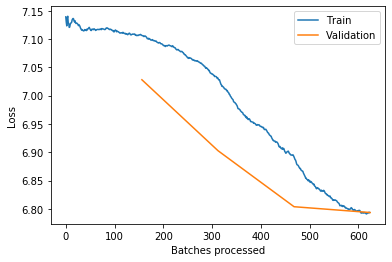

In [43]:
learn.recorder.plot_losses()

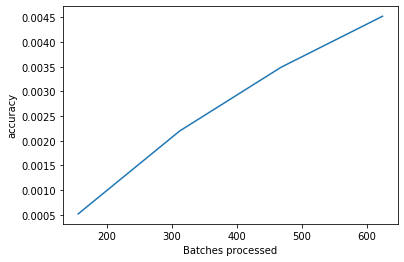

In [44]:
learn.recorder.plot_metrics()

In [45]:
#learn.recorder.plot_lr(show_moms=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 3.31E-05


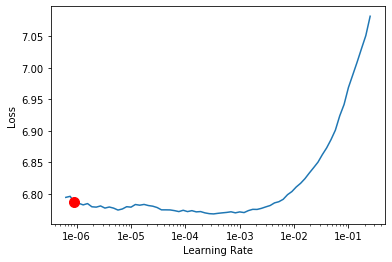

In [46]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [47]:
learn.fit_one_cycle(16, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,6.780805,6.793058,0.005169,03:03
1,6.768823,6.768906,0.003102,03:04
2,6.762675,6.757470,0.003619,03:05
3,6.722799,6.747814,0.004523,03:03
4,6.646468,6.720433,0.003877,03:03
5,6.549493,6.653822,0.007108,03:04
6,6.457099,6.573979,0.006720,03:02
7,6.357457,6.596412,0.008012,03:05
8,6.238839,6.552967,0.010597,03:04
9,6.105408,6.410344,0.012794,03:06


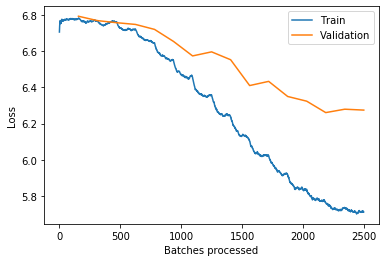

In [48]:
learn.recorder.plot_losses()

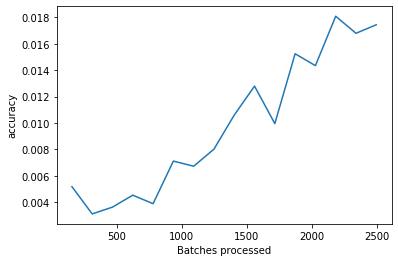

In [49]:
learn.recorder.plot_metrics()

In [50]:
learn.save('xresnet152fh_val-split-ex-v1_128px_e020_20190721', return_path=True)

PosixPath('train/models/xresnet152fh_val-split-ex-v1_128px_e020_20190721.pth')

In [51]:
learn.load('xresnet152fh_val-split-ex-v1_128px_e020_20190721');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-05
Min loss divided by 10: 4.37E-06


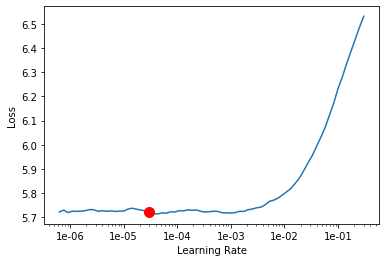

In [52]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [53]:
learn.fit_one_cycle(20, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,5.736735,6.271913,0.016542,03:04
1,5.750206,6.237713,0.018609,03:06
2,5.764630,6.275198,0.017446,03:07
3,5.782061,6.317126,0.016542,03:04
4,5.794617,6.307801,0.018609,03:05
5,5.725820,6.201957,0.019514,03:04
6,5.654782,6.325262,0.017317,03:04
7,5.556430,6.275567,0.019643,03:05
8,5.425997,6.191385,0.031016,03:06
9,5.312214,6.017239,0.030757,03:05


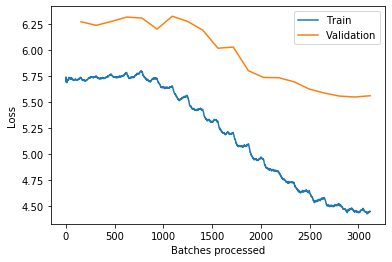

In [54]:
learn.recorder.plot_losses()

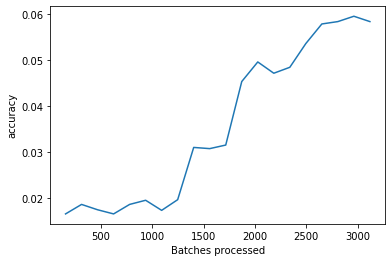

In [55]:
learn.recorder.plot_metrics()

In [56]:
learn.save('xresnet152fh_val-split-ex-v1_128px_e040_20190721', return_path=True)

PosixPath('train/models/xresnet152fh_val-split-ex-v1_128px_e040_20190721.pth')

In [57]:
learn.load('xresnet152fh_val-split-ex-v1_128px_e040_20190721');

In [58]:
# switch to mixup
learn.mixup();

Learner(data=ImageDataBunch;

Train: LabelList (28777 items)
x: ImageList6D
Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128)
y: CategoryList
513,840,1020,254,144
Path: train;

Valid: LabelList (7738 items)
x: ImageList6D
Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128)
y: CategoryList
352,361,503,505,70
Path: train;

Test: LabelList (19897 items)
x: ImageList6D
Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128)
y: EmptyLabelList
,,,,
Path: train, model=Sequential(
  (0): XResNetFeature(
    (0): Sequential(
      (0): Conv2d(6, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.20E-04


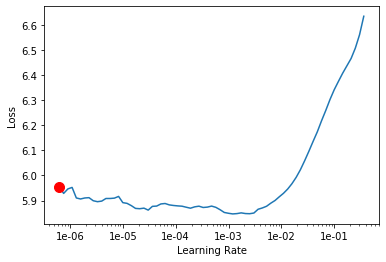

In [59]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [60]:
learn.fit_one_cycle(8, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,5.631413,5.759766,0.046782,03:03
1,5.698930,5.829951,0.042905,03:05
2,5.734103,6.042806,0.035539,03:05
3,5.661202,6.004486,0.042130,03:08
4,5.566839,5.695405,0.050530,03:03
5,5.456644,5.619204,0.055441,03:03
6,5.324374,5.481314,0.063970,03:05
7,5.251019,5.467087,0.067718,03:06


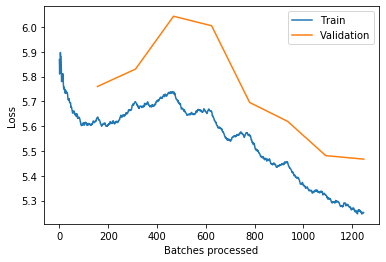

In [61]:
learn.recorder.plot_losses()

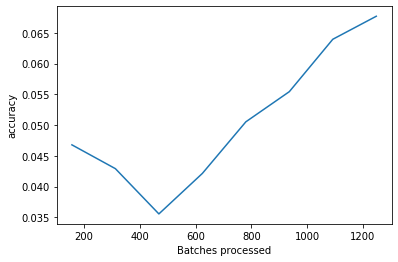

In [62]:
learn.recorder.plot_metrics()

In [66]:
learn.save('resnet152/xresnet152fh_val-split-ex-v1_128px_mixup_e048_20190721', return_path=True)

PosixPath('train/models/resnet152/xresnet152fh_val-split-ex-v1_128px_mixup_e048_20190721.pth')

In [67]:
learn.load('resnet152/xresnet152fh_val-split-ex-v1_128px_mixup_e048_20190721');

In [69]:
learn.fit_one_cycle(8, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,5.304587,5.520511,0.064099,03:07
1,5.464979,5.687278,0.052985,03:05
2,5.557710,5.698963,0.052985,03:05
3,5.477211,5.737346,0.053502,03:04
4,5.386480,5.441889,0.064228,03:05
5,5.241515,5.463047,0.067976,03:05
6,5.103537,5.368401,0.076764,03:07
7,5.066922,5.305137,0.082450,03:05


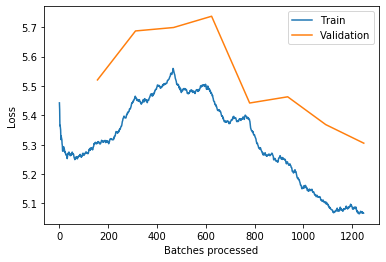

In [70]:
learn.recorder.plot_losses()

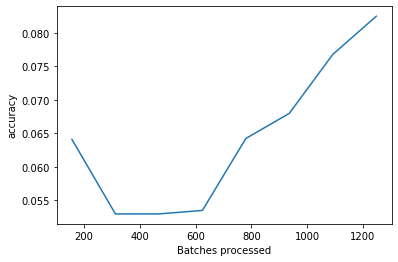

In [71]:
learn.recorder.plot_metrics()

In [72]:
learn.save('resnet152/xresnet152fh_val-split-ex-v1_128px_mixup_e056_20190721', return_path=True)

PosixPath('train/models/resnet152/xresnet152fh_val-split-ex-v1_128px_mixup_e056_20190721.pth')

In [73]:
learn.load('resnet152/xresnet152fh_val-split-ex-v1_128px_mixup_e056_20190721');

In [74]:
learn.fit_one_cycle(8, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,5.104648,5.319707,0.078056,03:06
1,5.280421,5.891646,0.051305,03:06
2,5.362111,5.830336,0.047428,03:05
3,5.311797,5.679920,0.058671,03:06
4,5.191258,5.536249,0.068105,03:06
5,5.045655,5.283491,0.086586,03:05
6,4.937920,5.225899,0.093047,03:07
7,4.886864,5.195045,0.095373,03:05


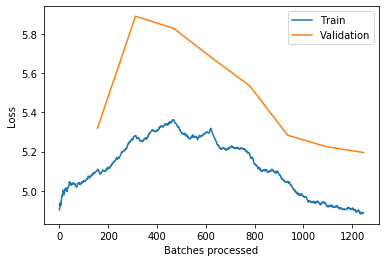

In [75]:
learn.recorder.plot_losses()

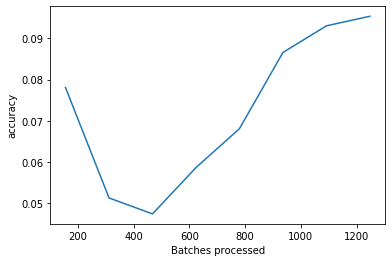

In [76]:
learn.recorder.plot_metrics()

In [77]:
learn.save('resnet152/xresnet152fh_val-split-ex-v1_128px_mixup_e064_20190721', return_path=True)

PosixPath('train/models/resnet152/xresnet152fh_val-split-ex-v1_128px_mixup_e064_20190721.pth')

In [78]:
learn.load('resnet152/xresnet152fh_val-split-ex-v1_128px_mixup_e064_20190721');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.10E-05


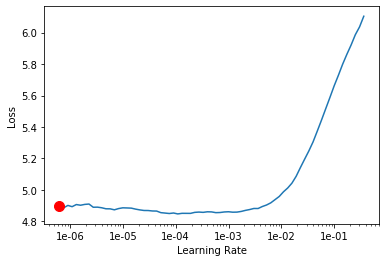

In [79]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [81]:
learn.fit_one_cycle(8, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.912584,5.285648,0.087103,03:05
1,5.118741,5.472508,0.078573,03:06
2,5.207138,5.408859,0.075084,03:04
3,5.151009,5.510554,0.069398,03:05
4,5.057180,5.381253,0.081029,03:06
5,4.919106,5.172675,0.096795,03:05
6,4.798452,5.086765,0.102094,03:06
7,4.714162,5.086166,0.102223,03:04


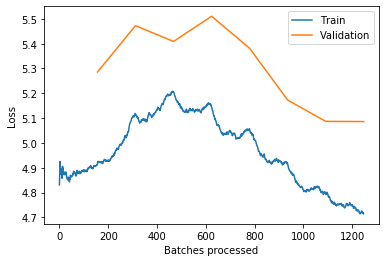

In [82]:
learn.recorder.plot_losses()

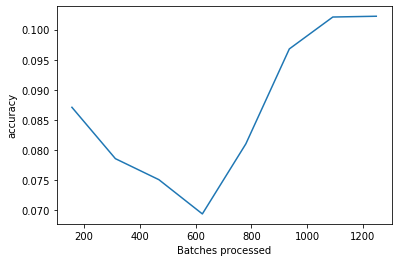

In [83]:
learn.recorder.plot_metrics()

In [84]:
learn.save('resnet152/xresnet152fh_val-split-ex-v1_128px_mixup_e072_20190721', return_path=True)

PosixPath('train/models/resnet152/xresnet152fh_val-split-ex-v1_128px_mixup_e072_20190721.pth')

In [85]:
learn.load('resnet152/xresnet152fh_val-split-ex-v1_128px_mixup_e072_20190721');

## se_xresnet152fh

In [35]:
from fastai.callbacks import CSVLogger, ReduceLROnPlateauCallback, SaveModelCallback

In [36]:
learn = Learner(data, se_xresnet152, metrics=[accuracy], callback_fns=[CSVLogger]).to_fp16()

### 128px Standard training

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06
Min loss divided by 10: 6.31E-08


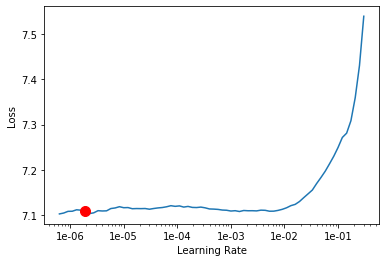

In [36]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [37]:
learn.fit_one_cycle(4, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,7.105698,6.999484,0.001422,03:07
1,6.993855,6.912116,0.002585,03:12
2,6.863742,6.832772,0.003619,03:09
3,6.766771,6.820724,0.003102,03:09


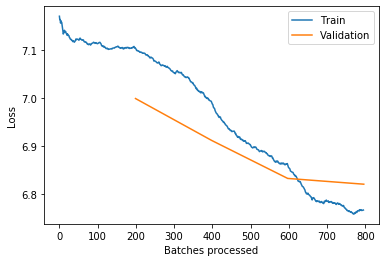

In [38]:
learn.recorder.plot_losses()

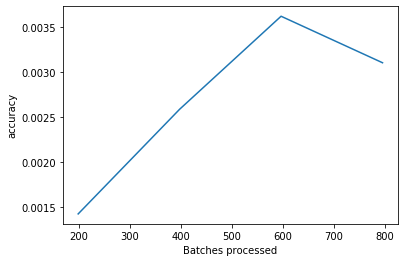

In [39]:
learn.recorder.plot_metrics()

In [40]:
#learn.recorder.plot_lr(show_moms=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06
Min loss divided by 10: 7.59E-06


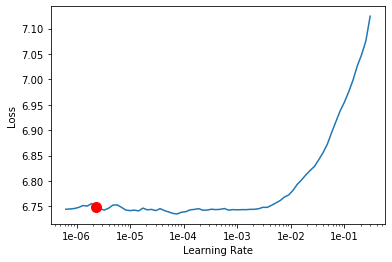

In [41]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [42]:
learn.fit_one_cycle(16, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,6.746562,6.792903,0.004135,03:10
1,6.762219,6.761935,0.004135,03:10
2,6.742943,6.822394,0.004394,03:11
3,6.721447,6.771562,0.003231,03:10
4,6.645291,6.716636,0.005815,03:10
5,6.550087,6.682614,0.006849,03:10
6,6.466308,6.675741,0.005815,03:09
7,6.331604,6.615339,0.007883,03:10
8,6.210035,6.505828,0.010985,03:10
9,6.103688,6.465230,0.011760,03:11


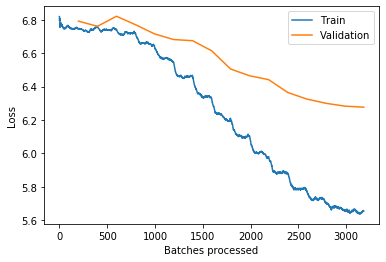

In [43]:
learn.recorder.plot_losses()

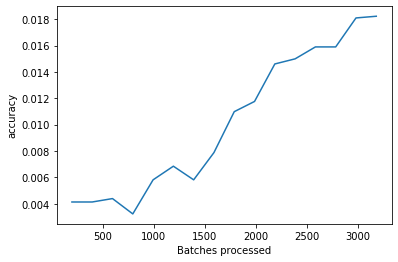

In [44]:
learn.recorder.plot_metrics()

In [45]:
learn.save('resnet152/se_xresnet152fh_val-split-ex-v1_128px_e020_20190721', return_path=True)

PosixPath('train/models/resnet152/se_xresnet152fh_val-split-ex-v1_128px_e020_20190721.pth')

In [46]:
learn.load('resnet152/se_xresnet152fh_val-split-ex-v1_128px_e020_20190721');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 1.58E-07


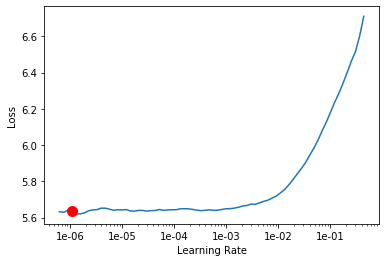

In [47]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [48]:
learn.fit_one_cycle(20, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,5.669261,6.275064,0.017705,03:10
1,5.692698,6.266332,0.017963,03:10
2,5.711780,6.250944,0.018093,03:12
3,5.721929,6.330987,0.015766,03:11
4,5.729168,6.365190,0.018093,03:11
5,5.685822,6.313947,0.019643,03:10
6,5.620446,6.248549,0.018868,03:12
7,5.517828,6.126643,0.024296,03:09
8,5.388877,6.014676,0.028173,03:12
9,5.278394,6.183850,0.029594,03:11


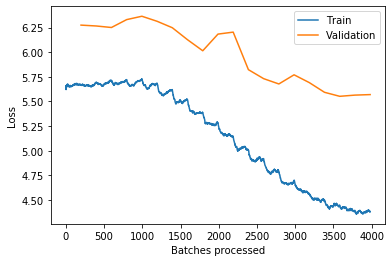

In [49]:
learn.recorder.plot_losses()

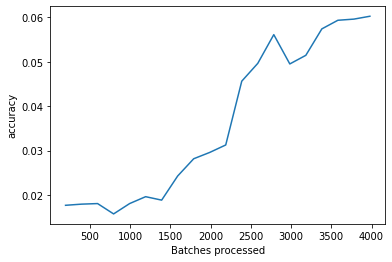

In [50]:
learn.recorder.plot_metrics()

In [51]:
learn.save('resnet152/se_xresnet152fh_val-split-ex-v1_128px_e040_20190721', return_path=True)

PosixPath('train/models/resnet152/se_xresnet152fh_val-split-ex-v1_128px_e040_20190721.pth')

In [52]:
learn.load('resnet152/se_xresnet152fh_val-split-ex-v1_128px_e040_20190721');

### MixUp

In [53]:
# switch to mixup
learn.mixup();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-04
Min loss divided by 10: 2.51E-04


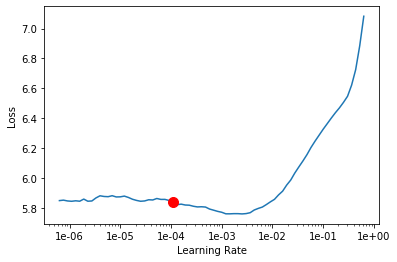

In [54]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [55]:
learn.fit_one_cycle(8, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,5.578407,5.698870,0.053631,03:09
1,5.706362,6.232685,0.031662,03:09
2,5.733232,5.908401,0.044585,03:12
3,5.671135,6.069799,0.038382,03:11
4,5.538858,5.634025,0.055441,03:11
5,5.409447,5.628281,0.053502,03:12
6,5.296424,5.526300,0.062807,03:12
7,5.236609,5.491017,0.066684,03:10


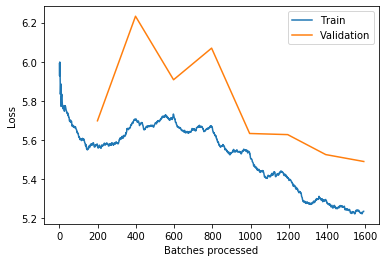

In [56]:
learn.recorder.plot_losses()

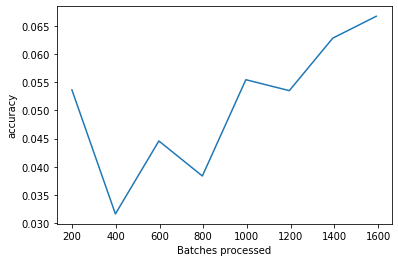

In [57]:
learn.recorder.plot_metrics()

In [58]:
learn.save('resnet152/se_xresnet152fh_val-split-ex-v1_128px_mixup_e048_20190721', return_path=True)

PosixPath('train/models/resnet152/se_xresnet152fh_val-split-ex-v1_128px_mixup_e048_20190721.pth')

In [59]:
learn.load('resnet152/se_xresnet152fh_val-split-ex-v1_128px_mixup_e048_20190721');

In [60]:
learn.fit_one_cycle(8, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,5.292242,5.526399,0.063712,03:10
1,5.462000,5.862166,0.047816,03:12
2,5.526124,6.020994,0.042776,03:11
3,5.467828,5.697974,0.058284,03:11
4,5.363342,5.664397,0.060222,03:12
5,5.189186,5.496943,0.067589,03:11
6,5.091708,5.349965,0.081158,03:11
7,5.011860,5.339547,0.081158,03:12


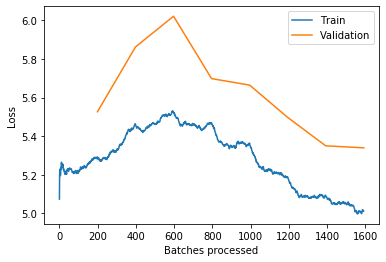

In [61]:
learn.recorder.plot_losses()

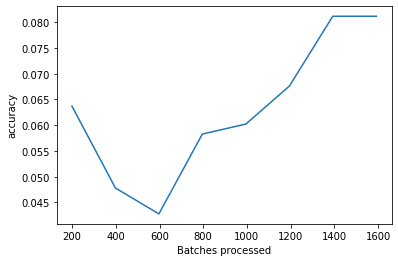

In [62]:
learn.recorder.plot_metrics()

In [63]:
learn.save('resnet152/se_xresnet152fh_val-split-ex-v1_128px_mixup_e056_20190721', return_path=True)

PosixPath('train/models/resnet152/se_xresnet152fh_val-split-ex-v1_128px_mixup_e056_20190721.pth')

In [64]:
learn.load('resnet152/se_xresnet152fh_val-split-ex-v1_128px_mixup_e056_20190721');

In [65]:
learn.fit_one_cycle(8, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,5.075588,5.313820,0.083355,03:11
1,5.256950,5.969660,0.049496,03:12
2,5.353426,5.625305,0.059964,03:10
3,5.271090,5.527109,0.064616,03:12
4,5.168220,5.480524,0.071982,03:11
5,5.052580,5.370643,0.077022,03:10
6,4.907413,5.204909,0.090980,03:12
7,4.831425,5.206250,0.090204,03:12


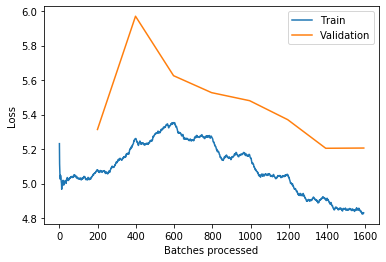

In [66]:
learn.recorder.plot_losses()

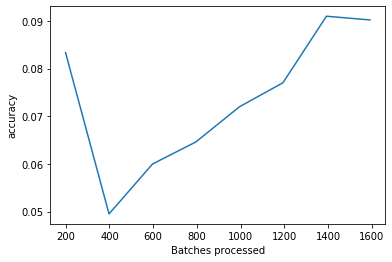

In [67]:
learn.recorder.plot_metrics()

In [68]:
learn.save('resnet152/se_xresnet152fh_val-split-ex-v1_128px_mixup_e064_20190721', return_path=True)

PosixPath('train/models/resnet152/se_xresnet152fh_val-split-ex-v1_128px_mixup_e064_20190721.pth')

In [69]:
learn.load('resnet152/se_xresnet152fh_val-split-ex-v1_128px_mixup_e064_20190721');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-05
Min loss divided by 10: 9.12E-08


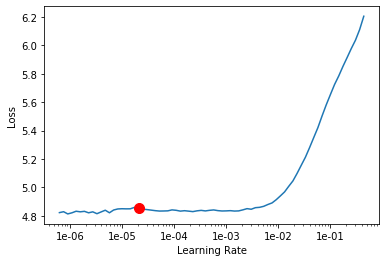

In [70]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [71]:
learn.fit_one_cycle(8, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.873679,5.291736,0.083226,03:09
1,5.110707,5.422216,0.077410,03:12
2,5.170142,5.420190,0.082063,03:11
3,5.136165,5.382519,0.084518,03:11
4,4.987693,5.286175,0.090075,03:11
5,4.872171,5.285758,0.086198,03:10
6,4.722084,5.091072,0.105841,03:10
7,4.663940,5.084283,0.107780,03:10


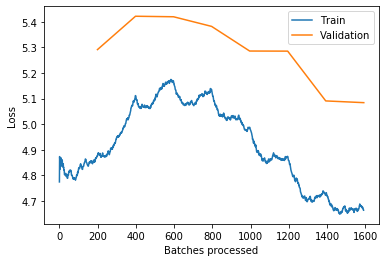

In [72]:
learn.recorder.plot_losses()

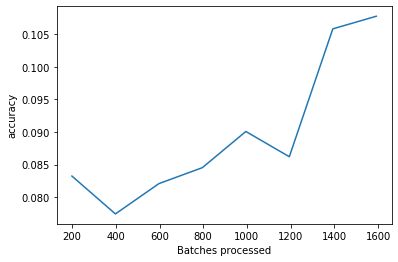

In [73]:
learn.recorder.plot_metrics()

In [74]:
learn.save('resnet152/se_xresnet152fh_val-split-ex-v1_128px_mixup_e072_20190721', return_path=True)

PosixPath('train/models/resnet152/se_xresnet152fh_val-split-ex-v1_128px_mixup_e072_20190721.pth')

In [36]:
learn.load('resnet152/se_xresnet152fh_val-split-ex-v1_128px_mixup_e072_20190721');

### New data augmentations

Based on https://github.com/oguiza/fastai_extensions/tree/master/shared/0_image_data_augmentation<br>
*Reload learner to get a learner without active mixup?*

#### RICAP

In [38]:
learn.ricap();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06
Min loss divided by 10: 7.59E-08


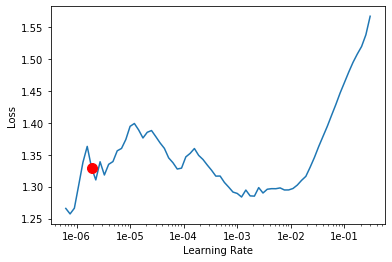

In [39]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [40]:
learn.fit_one_cycle(16, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.360752,5.210574,0.093435,03:11
1,1.354118,5.195010,0.094857,03:13
2,1.381563,5.451958,0.073404,03:13
3,1.342031,5.436921,0.075084,03:15
4,1.377151,5.313561,0.081416,03:15
5,1.390807,5.396116,0.075472,03:12
6,1.361634,5.292921,0.079349,03:14
7,1.320144,5.221164,0.090850,03:13
8,1.330189,5.114846,0.102610,03:15
9,1.294420,5.125564,0.101706,03:11


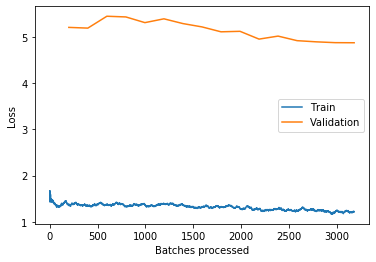

In [41]:
learn.recorder.plot_losses()

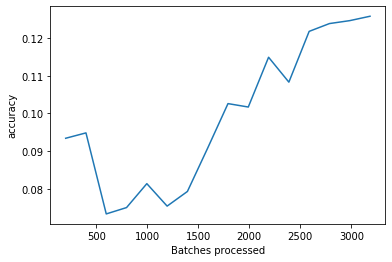

In [42]:
learn.recorder.plot_metrics()

In [43]:
learn.save('resnet152/se_xresnet152fh_val-split-ex-v1_128px_ricap_e088_20190721', return_path=True)

PosixPath('train/models/resnet152/se_xresnet152fh_val-split-ex-v1_128px_ricap_e088_20190721.pth')

In [44]:
learn.load('resnet152/se_xresnet152fh_val-split-ex-v1_128px_ricap_e088_20190721');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-08


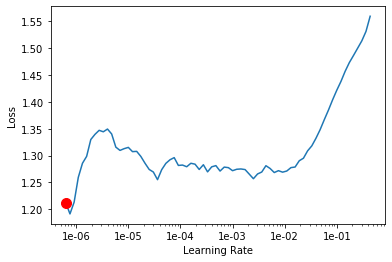

In [45]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [46]:
learn.fit_one_cycle(16, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.237611,4.906494,0.122254,03:12
1,1.273488,4.954375,0.113595,03:12
2,1.272340,5.020154,0.111269,03:14
3,1.286091,5.166870,0.096666,03:13
4,1.316195,5.103288,0.104161,03:14
5,1.343578,5.166669,0.095373,03:15
6,1.307838,5.225949,0.096537,03:14
7,1.276763,5.016953,0.106358,03:13
8,1.297923,5.045976,0.106358,03:15
9,1.263433,4.990234,0.117601,03:14


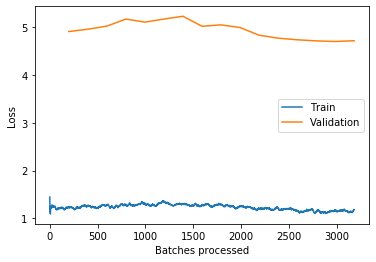

In [47]:
learn.recorder.plot_losses()

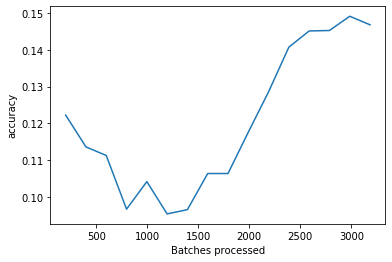

In [48]:
learn.recorder.plot_metrics()

In [49]:
learn.save('resnet152/se_xresnet152fh_val-split-ex-v1_128px_ricap_e104_20190721', return_path=True)

PosixPath('train/models/resnet152/se_xresnet152fh_val-split-ex-v1_128px_ricap_e104_20190721.pth')

In [36]:
learn.load('resnet152/se_xresnet152fh_val-split-ex-v1_128px_ricap_e104_20190721');

#### CutMix

In [39]:
learn.cutmix();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-06
Min loss divided by 10: 7.59E-08


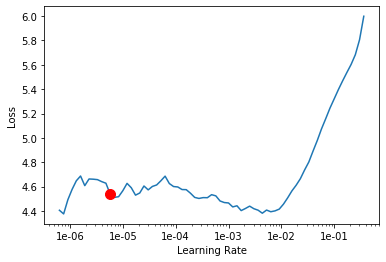

In [40]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [41]:
learn.fit_one_cycle(16, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.447052,4.681260,0.149522,03:09
1,4.479033,4.870638,0.127035,03:12
2,4.732055,4.944437,0.119669,03:11
3,4.567316,5.071791,0.104937,03:11
4,4.691999,5.034769,0.112949,03:12
5,4.797330,4.829290,0.131042,03:11
6,4.650947,4.970707,0.116309,03:12
7,4.780382,5.002037,0.116438,03:11
8,4.470402,4.767007,0.139183,03:12
9,4.511647,4.773554,0.137503,03:12


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



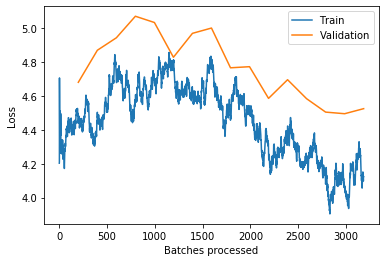

In [42]:
learn.recorder.plot_losses()

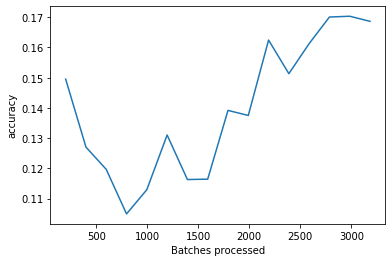

In [43]:
learn.recorder.plot_metrics()

In [44]:
learn.save('resnet152/se_xresnet152fh_val-split-ex-v1_128px_cutmix_e120_20190721', return_path=True)

PosixPath('train/models/resnet152/se_xresnet152fh_val-split-ex-v1_128px_cutmix_e120_20190721.pth')

In [45]:
learn.load('resnet152/se_xresnet152fh_val-split-ex-v1_128px_cutmix_e120_20190721');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.58E-05


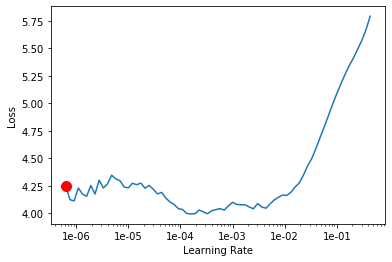

In [46]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [47]:
learn.fit_one_cycle(16, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.006761,4.514524,0.168777,03:10
1,4.167951,4.541775,0.166710,03:13
2,4.251705,4.915002,0.132075,03:13
3,4.462609,4.851645,0.130525,03:12
4,4.617206,4.944912,0.125226,03:12
5,4.372616,4.674441,0.151460,03:12
6,4.391039,4.812416,0.142026,03:11
7,4.534216,4.675994,0.158956,03:12
8,4.460336,4.686838,0.157147,03:10
9,4.256023,4.750566,0.149263,03:12


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



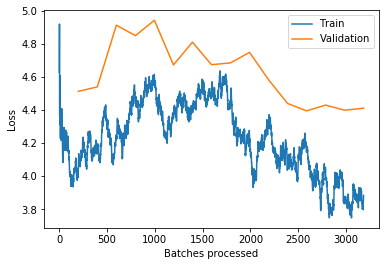

In [48]:
learn.recorder.plot_losses()

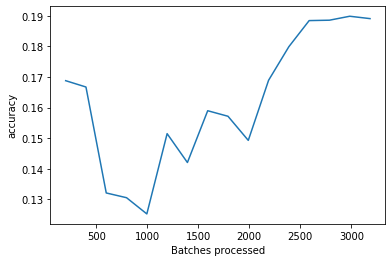

In [49]:
learn.recorder.plot_metrics()

In [50]:
learn.save('resnet152/se_xresnet152fh_val-split-ex-v1_128px_cutmix_e136_20190721', return_path=True)

PosixPath('train/models/resnet152/se_xresnet152fh_val-split-ex-v1_128px_cutmix_e136_20190721.pth')

In [37]:
learn.load('resnet152/se_xresnet152fh_val-split-ex-v1_128px_cutmix_e136_20190721');

### Overnight training with CutMix

In [38]:
redlr = ReduceLROnPlateauCallback(learn, monitor='valid_loss', patience=8)
savem = SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                          name='resnet152/se_xresnet152fh_val-split-ex-v1_128px_cutmix_e136-300_20190721_best')


In [39]:
learn.cutmix();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06
Min loss divided by 10: 3.31E-05


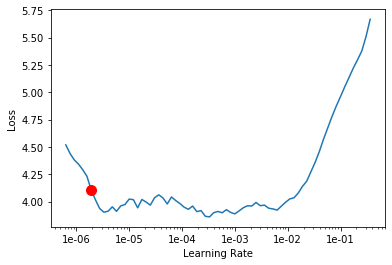

In [40]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [41]:
learn.fit(164, lr=1e-3, callbacks=[savem, redlr])

epoch,train_loss,valid_loss,accuracy,time
0,4.301439,4.707486,0.158051,03:11
1,4.456045,4.944226,0.130008,03:09
2,4.246356,4.693741,0.145903,03:13
3,4.393685,4.643875,0.162445,03:13
4,4.351354,4.938463,0.139700,03:14
5,4.207450,5.039445,0.123805,03:12
6,4.267758,4.743242,0.151977,03:13
7,4.200638,4.786302,0.150297,03:12
8,4.206478,4.733753,0.151073,03:12
9,4.302317,4.710161,0.154562,03:13


Better model found at epoch 0 with accuracy value: 0.15805117785930634.
Better model found at epoch 3 with accuracy value: 0.1624450832605362.
Epoch 12: reducing lr to 0.0002
Better model found at epoch 13 with accuracy value: 0.18131300806999207.
Better model found at epoch 14 with accuracy value: 0.18570689857006073.
Better model found at epoch 15 with accuracy value: 0.19514086842536926.
Better model found at epoch 21 with accuracy value: 0.20160247385501862.
Better model found at epoch 26 with accuracy value: 0.20392866432666779.
Epoch 35: reducing lr to 4e-05


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Better model found at epoch 72 with accuracy value: 0.20767639577388763.
Epoch 76: reducing lr to 6.400000000000003e-08


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 159: reducing lr to 1.6384000000000016e-13


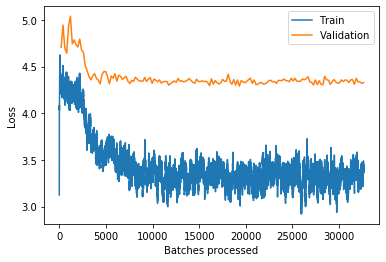

In [42]:
learn.recorder.plot_losses()

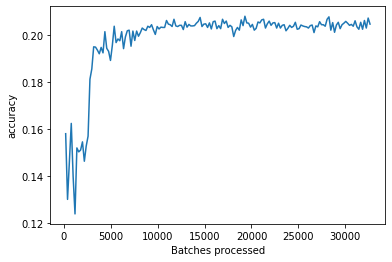

In [43]:
learn.recorder.plot_metrics()

In [44]:
learn.save('resnet152/se_xresnet152fh_val-split-ex-v1_128px_cutmix_e300_20190721', return_path=True)

PosixPath('train/models/resnet152/se_xresnet152fh_val-split-ex-v1_128px_mixup_e300_20190721_best.pth')

In [45]:
learn.load('resnet152/se_xresnet152fh_val-split-ex-v1_128px_cutmix_e300_20190721');

### 256px CutMix

In [37]:
learn.load('resnet152/se_xresnet152fh_val-split-ex-v1_128px_cutmix_e136-300_20190721_best');

In [36]:
learn.cutmix();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 4.37E-04


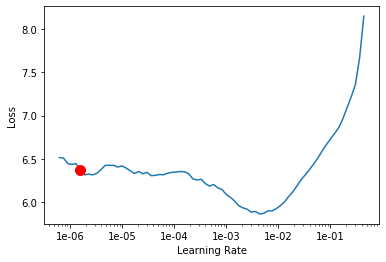

In [39]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [40]:
learn.fit_one_cycle(4, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.883663,5.030700,0.119411,08:39
1,4.968799,4.846511,0.141639,08:39
2,4.636680,4.384032,0.200310,08:39
3,4.140049,4.317788,0.213880,08:39


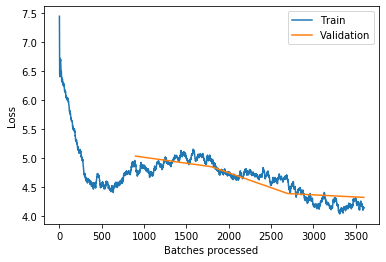

In [41]:
learn.recorder.plot_losses()

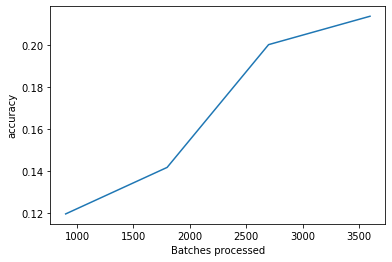

In [42]:
learn.recorder.plot_metrics()

In [43]:
learn.save('resnet152/se_xresnet152fh_val-split-ex-v1_cutmix_128e300_256e004_20190722', return_path=True)

PosixPath('train/models/resnet152/se_xresnet152fh_val-split-ex-v1_cutmix_128e300_256e004_20190722.pth')

In [37]:
learn.load('resnet152/se_xresnet152fh_val-split-ex-v1_cutmix_128e300_256e004_20190722');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06
Min loss divided by 10: 2.29E-07


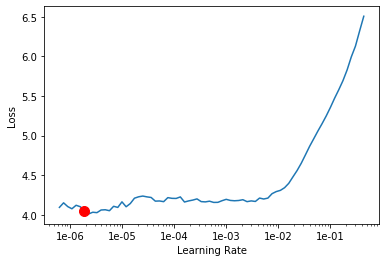

In [45]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [38]:
learn.fit_one_cycle(4, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.839034,4.691266,0.165547,08:41
1,5.140900,4.758024,0.156113,08:42
2,4.590767,4.365479,0.201086,08:38
3,4.374051,4.280193,0.218015,08:40


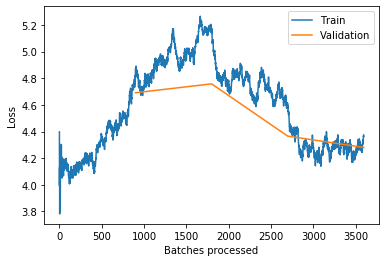

In [39]:
learn.recorder.plot_losses()

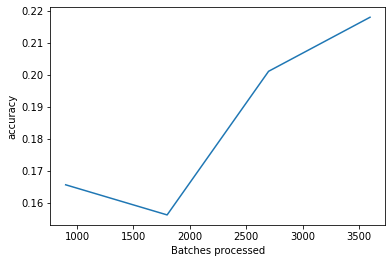

In [40]:
learn.recorder.plot_metrics()

In [41]:
learn.save('resnet152/se_xresnet152fh_val-split-ex-v1_cutmix_128e300_256e008_20190722')

In [36]:
learn.load('resnet152/se_xresnet152fh_val-split-ex-v1_cutmix_128e300_256e008_20190722');

#### Overday training with CutMix

In [46]:
redlr = ReduceLROnPlateauCallback(learn, monitor='valid_loss', patience=4)
savem = SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                          name='resnet152/se_xresnet152fh_val-split-ex-v1_cutmix_128e300_256e008-070_20190722_best')


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-05
Min loss divided by 10: 1.20E-04


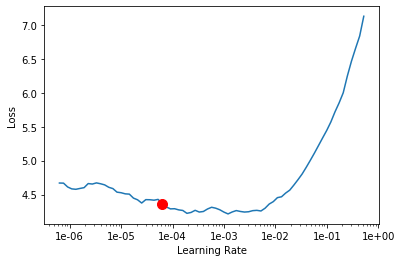

In [44]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit(62, lr=1e-3, callbacks=[savem, redlr])

epoch,train_loss,valid_loss,accuracy,time
0,5.287754,4.905490,0.143060,08:39
1,5.117485,4.950766,0.137891,08:40
2,5.207972,4.985909,0.134014,08:40
3,5.159881,4.867189,0.144353,08:40
4,5.171852,4.659524,0.168390,08:39
5,5.067389,4.697672,0.160894,08:40
6,5.123853,4.795507,0.156113,08:40
7,5.102754,4.592506,0.178728,08:38
8,5.099337,4.626031,0.166581,08:39
9,5.079603,4.689824,0.161153,08:38


Better model found at epoch 0 with accuracy value: 0.14306022226810455.
Better model found at epoch 3 with accuracy value: 0.14435254037380219.
Better model found at epoch 4 with accuracy value: 0.16838976740837097.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Better model found at epoch 13 with accuracy value: 0.1970793455839157.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Better model found at epoch 24 with accuracy value: 0.28146809339523315.
Better model found at epoch 25 with accuracy value: 0.2854742705821991.
Better model found at epoch 26 with accuracy value: 0.2881881594657898.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Better model found at epoch 46 with accuracy value: 0.3168777525424957.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Better model found at epoch 56 with accuracy value: 0.3257947862148285.


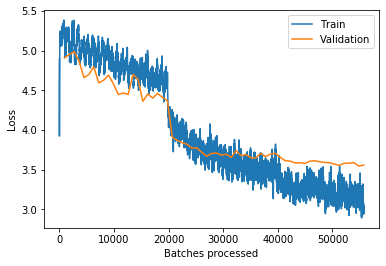

In [52]:
learn.recorder.plot_losses()

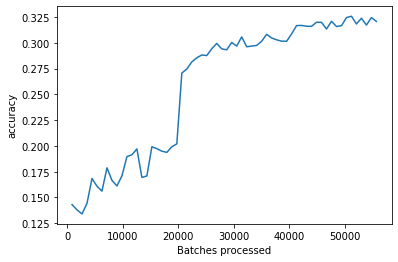

In [53]:
learn.recorder.plot_metrics()

In [54]:
learn.save('resnet152/se_xresnet152fh_val-split-ex-v1_cutmix_128e300_256e070_20190722')

In [55]:
learn.load('resnet152/se_xresnet152fh_val-split-ex-v1_cutmix_128e300_256e070_20190722');

### 512px CutMix - Directly CutMix is NOT WORKING!

In [36]:
learn.load('resnet152/se_xresnet152fh_val-split-ex-v1_cutmix_128e300_256e008-070_20190722_best64');

In [37]:
learn.cutmix();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 3.98E-07


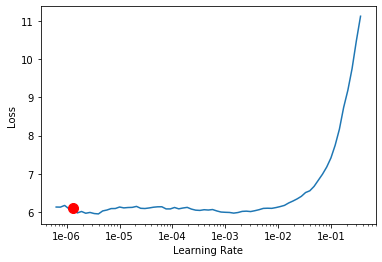

In [38]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [39]:
learn.fit_one_cycle(4, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,7.451660,7.707880,0.001163,33:01
1,7.243921,25.076933,0.001163,33:10
2,7.133909,12.516063,0.001292,33:06
3,7.090774,16.308376,0.001422,33:07


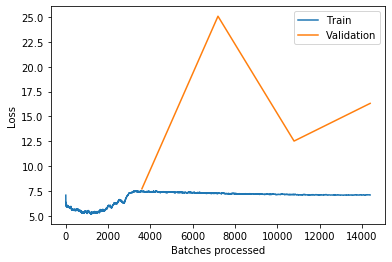

In [40]:
learn.recorder.plot_losses()

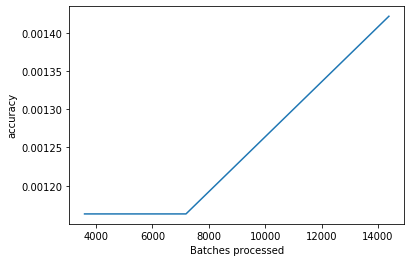

In [41]:
learn.recorder.plot_metrics()

In [42]:
learn.save('resnet152/se_xresnet152fh_val-split-ex-v1_cutmix_128e300_256e064_512e004_20190722')

In [43]:
learn.load('resnet152/se_xresnet152fh_val-split-ex-v1_cutmix_128e300_256e064_512e004_20190722');

### 512px Normal pretraining and then CutMix

In [38]:
learn.load('resnet152/se_xresnet152fh_val-split-ex-v1_cutmix_128e300_256e008-070_20190722_best64');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-08


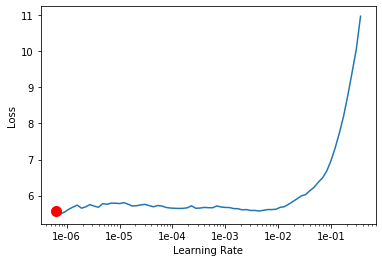

In [39]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [40]:
learn.fit_one_cycle(4, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,7.292263,6.890556,0.012536,33:00
1,7.314179,9.116003,0.000646,32:59
2,7.175919,21.559238,0.000646,32:44
3,7.135457,nan,0.000775,32:39


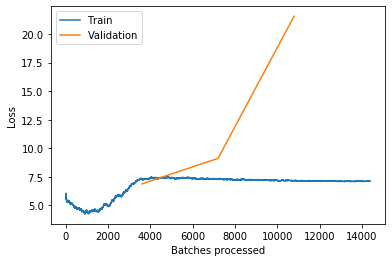

In [41]:
learn.recorder.plot_losses()

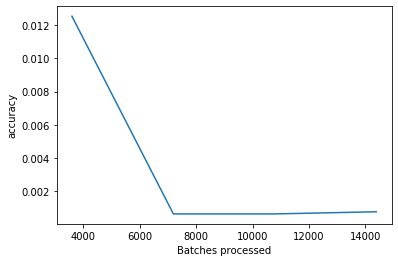

In [42]:
learn.recorder.plot_metrics()

In [43]:
learn.save('resnet152/se_xresnet152fh_val-split-ex-v1_128e300_256e064_512e004_20190723')

In [44]:
learn.load('resnet152/se_xresnet152fh_val-split-ex-v1_128e300_256e064_512e004_20190723');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.31E-05


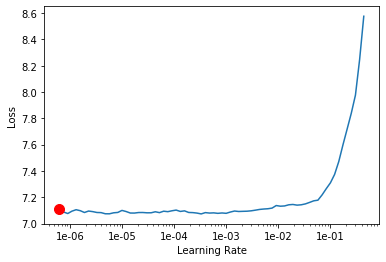

In [45]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [36]:
learn.load('resnet152/se_xresnet152fh_val-split-ex-v1_cutmix_128e300_256e064_512e004_20190722');

In [37]:
learn.cutmix();

In [38]:
learn.fit_one_cycle(8, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,7.101273,38.909843,0.001163,32:49
1,7.133346,7.180898,0.001034,32:54
2,7.094008,nan,0.000905,32:54
3,7.075759,19.440695,0.000646,32:52
4,7.048816,57.995411,0.000517,32:49
5,7.032552,85.799805,0.000905,32:51


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



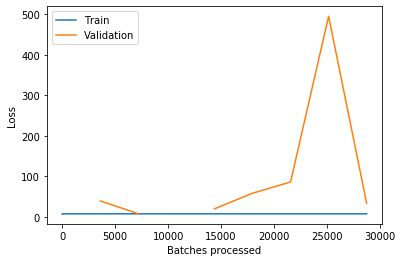

In [39]:
learn.recorder.plot_losses()

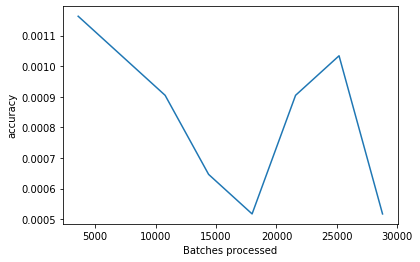

In [40]:
learn.recorder.plot_metrics()

In [41]:
learn.save('resnet152/se_xresnet152fh_val-split-ex-v1_cutmix_128e300_256e064_512e012_20190723')

In [42]:
learn.load('resnet152/se_xresnet152fh_val-split-ex-v1_cutmix_128e300_256e064_512e012_20190723');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.29E-03


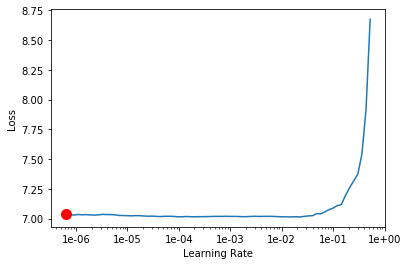

In [43]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [44]:
learn.fit_one_cycle(8, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,7.015601,7.252703,0.000775,32:47
1,7.046459,34.177273,0.001034,32:49
2,7.058798,19.798729,0.001163,32:50
3,7.048987,inf,0.000775,32:44
4,7.040378,9.523268,0.001034,32:46
5,7.031253,154.354233,0.000775,32:49


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



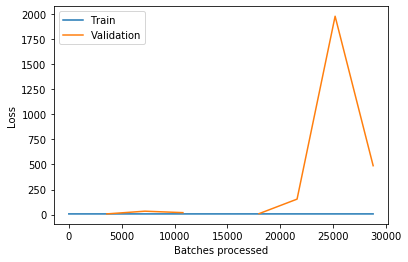

In [45]:
learn.recorder.plot_losses()

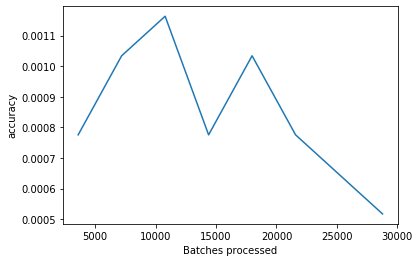

In [46]:
learn.recorder.plot_metrics()

In [47]:
learn.save('resnet152/se_xresnet152fh_val-split-ex-v1_cutmix_128e300_256e064_512e020_20190723')

In [48]:
learn.load('resnet152/se_xresnet152fh_val-split-ex-v1_cutmix_128e300_256e064_512e020_20190723');

### 512px less 256px pretraining

In [37]:
learn.load('resnet152/se_xresnet152fh_val-split-ex-v1_cutmix_128e300_256e008_20190722');

In [38]:
learn.cutmix();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-06
Min loss divided by 10: 3.63E-04


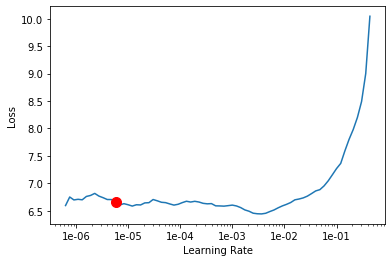

In [39]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [40]:
learn.fit_one_cycle(4, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,7.311288,7.083768,0.001680,33:10
1,7.163325,25.704067,0.000905,33:06


Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mmp/anaconda3/envs/fastai/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
Traceback (most recent call last):
  File "/home/mmp/anaconda3/envs/fastai/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/mmp/anaconda3/envs/fastai/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/mmp/anaconda3/envs/fastai/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/mmp/anaconda3/envs/fastai/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/mmp/anaconda3/envs/fastai/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
  File "/home/mmp/anaconda3/envs/fastai/lib/python3.6/multiproc

KeyboardInterrupt: 

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()

In [42]:
#learn.save('resnet152/se_xresnet152fh_val-split-ex-v1_cutmix_128e300_256e064_512e004_20190722')

In [43]:
#learn.load('resnet152/se_xresnet152fh_val-split-ex-v1_cutmix_128e300_256e064_512e004_20190722');

# Submission

## Get predicitions

In [49]:
model = 'se_xresnet152fh_val-split-ex-v1_cutmix_128e300_256e064_512e020_20190723'

In [58]:
#learn.load('resnet152/'+model)

Learner(data=ImageDataBunch;

Train: LabelList (28777 items)
x: ImageList6D
Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256)
y: CategoryList
513,840,1020,254,144
Path: train;

Valid: LabelList (7738 items)
x: ImageList6D
Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256)
y: CategoryList
352,361,503,505,70
Path: train;

Test: LabelList (19897 items)
x: ImageList6D
Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256)
y: EmptyLabelList
,,,,
Path: train, model=Sequential(
  (0): SE_XResNetFeature(
    (0): Sequential(
      (0): Conv2d(6, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1,

In [50]:
# get prediction of test dataset
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [51]:
# check length
len(preds)

19897

In [52]:
#preds

In [53]:
# get the categories
preds_cat = preds.argmax(dim=-1)

In [54]:
# get the names
preds_names = learn.data.test_ds.x.items

In [55]:
preds_names = [x.split('/')[1]+'_'+x.split('/')[2][-1]+'_'+x.split('/')[3][:3] for x in preds_names]
# including sX
#preds_names = [x.split('/')[1]+'_'+x.split('/')[2][-1]+'_'+x.split('/')[3] for x in preds_names]

In [56]:
df_preds = pd.DataFrame({'id_code': preds_names, 'sirna': preds.argmax(dim=-1)})

In [57]:
df_preds.head()

,id_code,sirna
0,HEPG2-08_1_B03,132
1,HEPG2-08_1_B04,445
2,HEPG2-08_1_B05,132
3,HEPG2-08_1_B06,577
4,HEPG2-08_1_B07,132


In [58]:
df_preds.to_csv('sub/'+model+'.csv.gz', index=False, compression='gzip')

In [59]:
!kaggle competitions submit -c recursion-cellular-image-classification -f sub/{model}.csv.gz -m "{model}"


100%|██████████████████████████████████████| 55.3k/55.3k [00:02<00:00, 19.3kB/s]
Successfully submitted to Recursion Cellular Image Classification

### TTA

In [ ]:
# get TTA prediction of test dataset
learn.to_fp32();
preds, _ = learn.TTA(ds_type=DatasetType.Test)

In [ ]:
# check length
len(preds)

In [ ]:
#preds

In [ ]:
# get the categories
preds_cat = preds.argmax(dim=-1)

In [ ]:
# get the names
preds_names = learn.data.test_ds.x.items

In [ ]:
preds_names = [x.split('/')[1]+'_'+x.split('/')[2][-1]+'_'+x.split('/')[3][:3] for x in preds_names]
# including sX
#preds_names = [x.split('/')[1]+'_'+x.split('/')[2][-1]+'_'+x.split('/')[3] for x in preds_names]

In [ ]:
df_preds = pd.DataFrame({'id_code': preds_names, 'sirna': preds.argmax(dim=-1)})

In [ ]:
df_preds.head()

In [ ]:
df_preds.to_csv('sub/'+model+'_TTA.csv.gz', index=False, compression='gzip')

In [ ]:
!kaggle competitions submit -c recursion-cellular-image-classification -f sub/{model}_TTA.csv.gz -m "{model}"


# Others

## Callback

In [ ]:
# https://docs.fast.ai/callback.html#callback

In [ ]:
# https://docs.fast.ai/callbacks.general_sched.html
def grl_scheduling(learn, n_cycles):
    '''Gradient reversal layer scheduling'''
    n = len(learn.data.train_dl)
    phases = [(TrainingPhase(n).schedule_hp('grl_factor', grl, anneal=annealing_cos))
              for i in range(n_cycles)]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    #learn. ??
    
    #if cycle_mult != 1:
    #    total_epochs = int(cycle_len * (1 - (cycle_mult)**n_cycles)/(1-cycle_mult)) 
    #else: total_epochs = n_cycles * cycle_len
    #learn.fit(total_epochs)

In [ ]:
# https://docs.fast.ai/callback.html#OptimWrapper
# OptimWrapper needed with the 'grl' parameter?

In [ ]:
# Einfacher Callback mit nur 'on_train_begin'???

# Oder besser (?): monkey-patch optimizer mit 'grl' Variable
# und dann Adaptierung der 'grl_scheduling' Funktion!